In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import GaussianBlur
import lovely_tensors as lt
from nnfabrik.builder import get_data
# from lurz2020.datasets.mouse_loaders import static_loaders
# from lurz2020.models.models import se2d_fullgaussian2d
# from lurz2020.training.trainers import standard_trainer as trainer
# from lurz2020.utility.measures import get_correlations, get_fraction_oracles

import csng
from csng.InvertedEncoder import InvertedEncoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters
from csng.losses import SSIMLoss, MSELossWithCrop
from csng.data import MixedBatchLoader

from encoder import get_encoder
from data_utils import get_mouse_v1_data, PerSampleStoredDataset

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

DATA_PATH='/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Train
- **DEPRECIATED** - see the `train_encoder` notebook for the latest version.

In [ ]:
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"].update({
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": False,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 64,
        "seed": config["seed"],
        "use_cache": False,
    },
})

dataloaders = get_data(config["data"]["dataset_fn"], config["data"]["dataset_config"])

In [ ]:
config["encoder"] = {
    "model_config": {
        "init_mu_range": 0.55,
        "init_sigma": 0.4,
        "input_kern": 15,
        "hidden_kern": 13,
        "gamma_input": 1.0,
        "grid_mean_predictor": {
            "type": "cortex",
            "input_dimensions": 2,
            "hidden_layers": 0,
            "hidden_features": 0,
            "final_tanh": False
        },
        "gamma_readout": 2.439,
    },
    # "load_ckpt": "../Lurz_2020_code/notebooks/models/transfer_model.pth.tar",
    "load_ckpt": None,
    "trainer_config": {
        "track_training": True,
        "detach_core": False, # detach core of encoder (not fine-tune)
        "max_iter": 300,
        "patience": 10,
        "device": config["device"],
    }
}
model = se2d_fullgaussian2d(**config["encoder"]["model_config"], dataloaders=dataloaders, seed=config["seed"])

In [ ]:
### load pretrained model (from Lurz et al. 2020)
if config["encoder"]["load_ckpt"] is not None:
    ckpt_transfer = torch.load(config["encoder"]["load_ckpt"])
    model.load_state_dict(ckpt_transfer, strict=False)
    print(f"Loaded pretrained model from {config['encoder']['load_ckpt']}")

In [ ]:
### train
score, output, model_state = trainer(
    model=model,
    dataloaders=dataloaders,
    seed=config["seed"],
    **config["encoder"]["trainer_config"]
)

### save the model state
torch.save({
    "encoder_state": model_state,
    "config": config,
    "history": output,
    "score": score,
}, "model_state.pt")

In [ ]:
### eval
train_correlation = get_correlations(model, dataloaders["train"], device=config["device"], as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device=config["device"], as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device=config["device"], as_dict=False, per_neuron=False)

print(f"Correlation (train set):      {train_correlation:.3f}")
print(f"Correlation (validation set): {validation_correlation:.3f}")
print(f"Correlation (test set):       {test_correlation:.3f}")

## Encoder Inversion

#### Data

In [4]:
### prep data config
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            # os.path.join(DATA_PATH, "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # mouse 1
            # os.path.join(DATA_PATH, "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # sensorium+ (mouse 2)
            os.path.join(DATA_PATH, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 3)
            # os.path.join(DATA_PATH, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 4)
            # os.path.join(DATA_PATH, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 5)
            # os.path.join(DATA_PATH, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 6)
            # os.path.join(DATA_PATH, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 7)
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 512,
        "seed": config["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

Training dataset:	 4608 samples
Validation dataset:	 1024 samples
Test dataset:		 105 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([7, 1, 36, 64])
  min=-1.750  max=2.225
  mean=0.093  std=0.944
responses:
  torch.Size([7, 8372])
  min=0.000  max=12.693
  mean=0.290  std=0.544
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


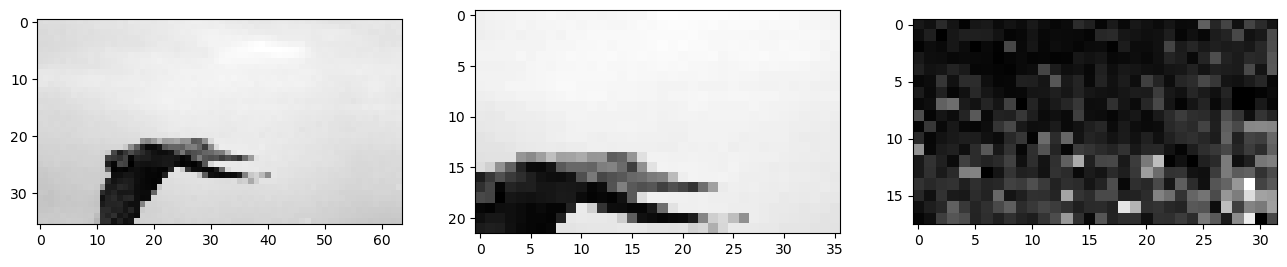

In [5]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

#### Load Encoder

In [6]:
encoder = get_encoder(ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22.pth"), device=config["device"], eval_mode=True)

Loading encoder checkpoint from /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/encoder_sens22.pth


In [ ]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

#### Run Inversion

In [7]:
def plot_loss_history(history):
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(121)
    ax.plot(history["resp_loss"])
    ax.set_title("resp_loss")

    ax = fig.add_subplot(122)
    ax.plot(history["stim_loss"])
    ax.set_title("stim_loss")
    plt.show()

In [8]:
### set targets
target_stim = stim.float().to(config["device"])
target_resp = resp.float().to(config["device"])
target_pupil_center = pupil_center.float().to(config["device"])
data_key = sample_data_key

In [45]:
### config
config["enc_inv"] = {
    "encoder": encoder,
    "img_dims": stim.shape[1:],
    "stim_pred_init": "zeros",
    "opter_cls": torch.optim.SGD,
    "opter_config": {"lr": 1500, "momentum": 0.},
    "n_steps": 400,
    "resp_loss_fn": F.mse_loss,
    "stim_loss_fn": SSIMLoss(
        window=config["crop_win"],
        log_loss=True,
        inp_normalized=True,
        inp_standardized=False,
    ),
    "img_gauss_blur_config": None,
    "img_grad_gauss_blur_config": {"kernel_size": 17, "sigma": 2},
    "device": config["device"],
}

[WARNING] Setting nonnegative_ssim to True as log_loss is set to True.


In [48]:
config["enc_inv"]["img_grad_gauss_blur_config"]

{'kernel_size': 17, 'sigma': 2}

1.2647489309310913


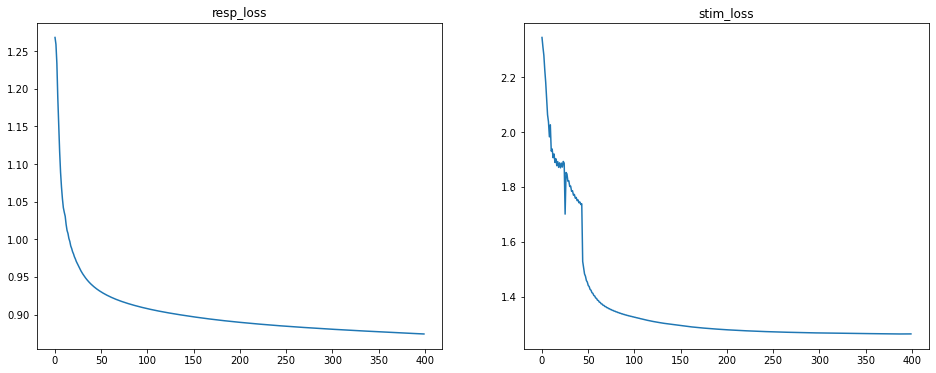

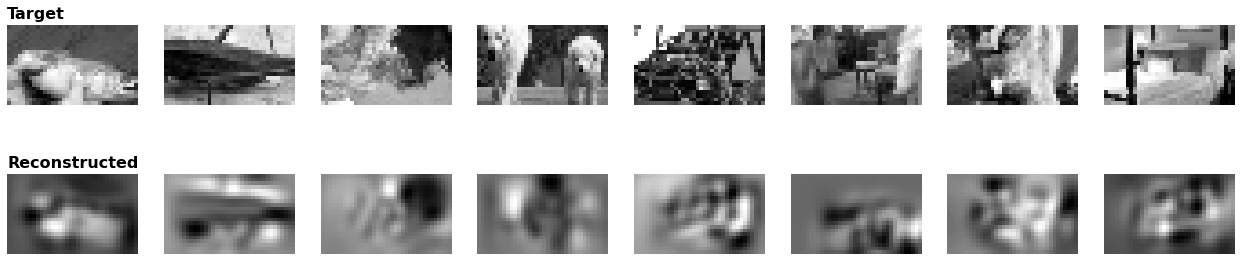

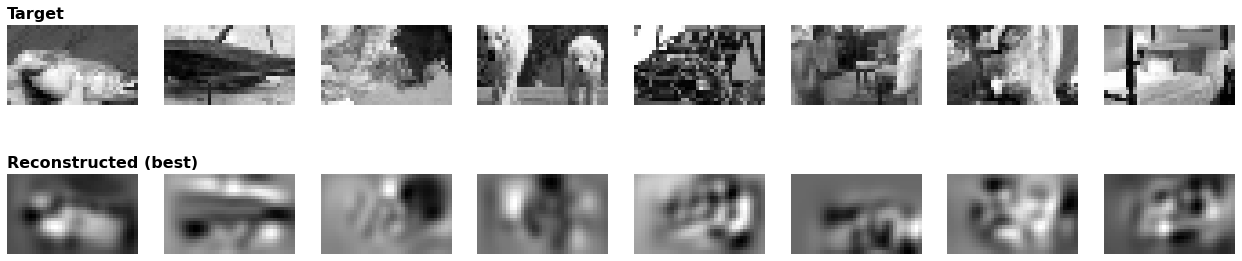

In [46]:
model = InvertedEncoder(**config["enc_inv"]).to(config["device"])
stim_pred, _, history = model(
    resp_target=target_resp,
    stim_target=target_stim,
    additional_encoder_inp={
        "data_key": data_key,
        "pupil_center": target_pupil_center,
    }
)
stim_pred_best = history["best"]["stim_pred"]

### show the results
print(history["best"]["stim_loss"])
plot_loss_history(history)
stim_pred_best = history["best"]["stim_pred"]
plot_comparison(target=crop(target_stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).detach().cpu())
plot_comparison(target=crop(target_stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred_best[:8], config["crop_win"]).detach().cpu(), pred_title="Reconstructed (best)");

#### Hyperparam search

In [17]:
### hyperparam configs
config_updates = [
    {"opter_config": {"lr": 1000}, "img_grad_gauss_blur_config": dict(kernel_size=11, sigma=2.)},
    {"opter_config": {"lr": 1000}, "img_grad_gauss_blur_config": dict(kernel_size=13, sigma=2.)},
    {"opter_config": {"lr": 1000}, "img_grad_gauss_blur_config": dict(kernel_size=15, sigma=2.)},

    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=13, sigma=2.5)},
    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=15, sigma=2.5)},
    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=17, sigma=2.5)},
    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=21, sigma=2.5)},

    {"opter_config": {"lr": 1000, "momentum": 0}, "img_grad_gauss_blur_config": dict(kernel_size=15, sigma=2.5)},
    {"opter_config": {"lr": 1000, "momentum": 0}, "img_grad_gauss_blur_config": dict(kernel_size=17, sigma=2.5)},
]

In [15]:
### run
results = []
for i, config_update in enumerate(config_updates):
    print(f"[{i+1}/{len(config_updates)}]")
    run_config = deepcopy(config)
    run_config["enc_inv"].update(config_update)
    model = InvertedEncoder(**run_config["enc_inv"]).to(config["device"])
    stim_pred, _, history = model(
        resp_target=target_resp,
        stim_target=target_stim,
        additional_encoder_inp={
            "data_key": data_key,
            "pupil_center": target_pupil_center,
        }
    )
    stim_pred_best = history["best"]["stim_pred"]
    results.append({"run_config": run_config, "stim_pred": stim_pred, "history": history})

[1/20]
[2/20]
[3/20]
[4/20]
[5/20]
[6/20]
[7/20]
[8/20]
[9/20]
[10/20]
[11/20]
[12/20]
[13/20]
[14/20]
[15/20]
[16/20]
[17/20]
[18/20]
[19/20]
[20/20]


lr=500, sigma=2.5, ker_sz=13   1.29229


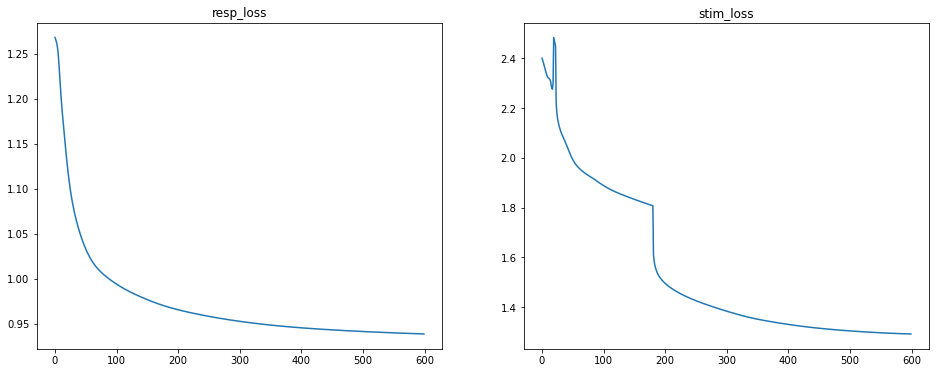

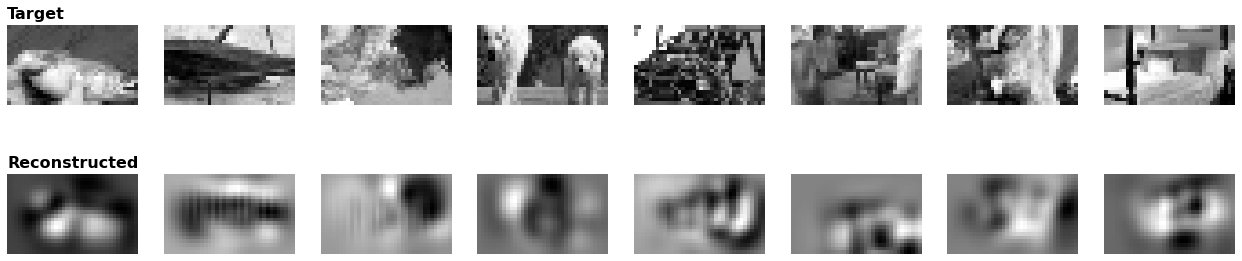

lr=500, sigma=2.5, ker_sz=15   1.30591


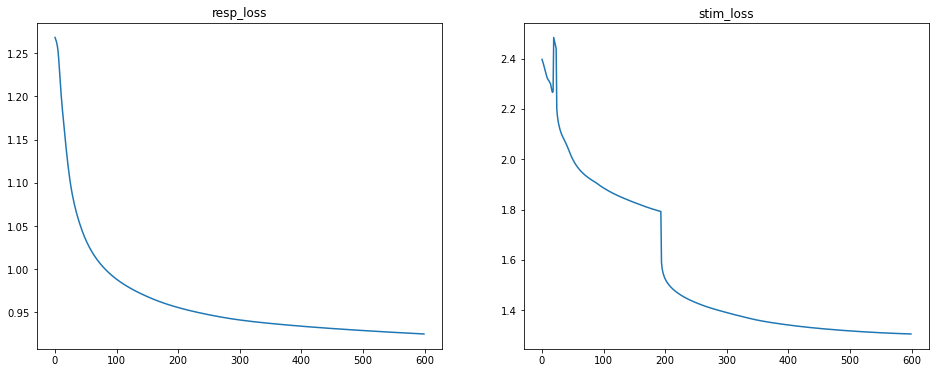

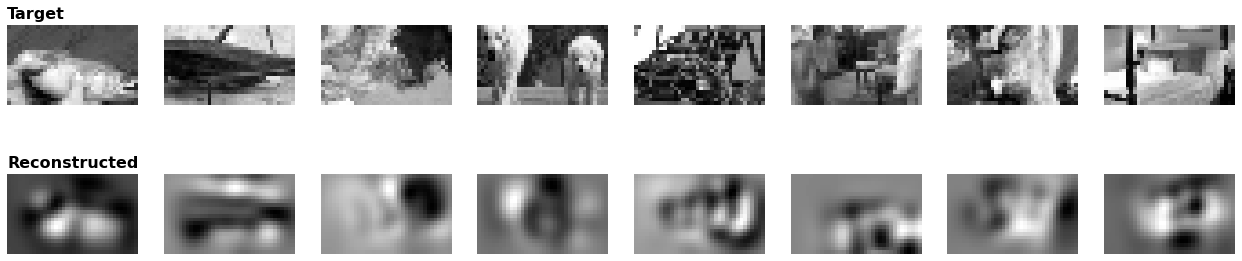

lr=500, sigma=2.5, ker_sz=17   1.29786


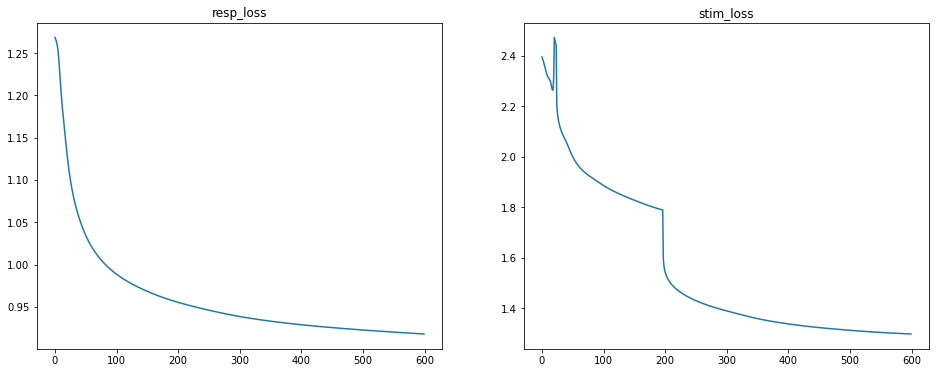

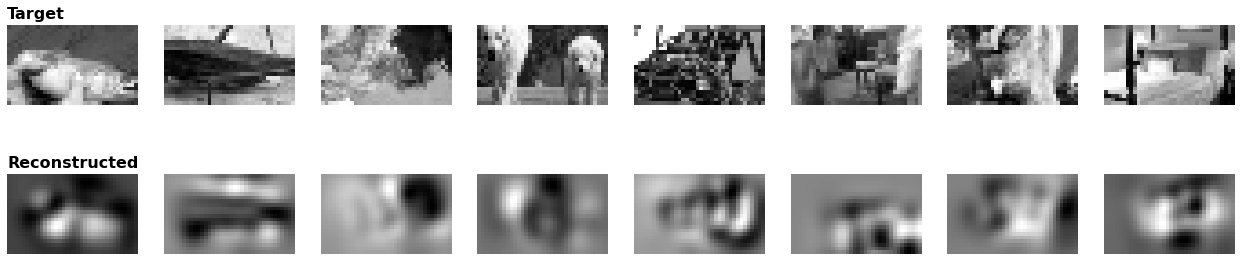

lr=500, sigma=2.5, ker_sz=21   1.29757


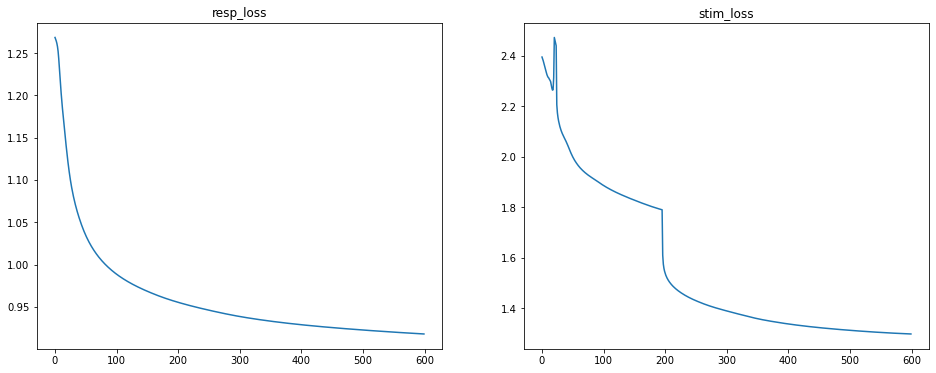

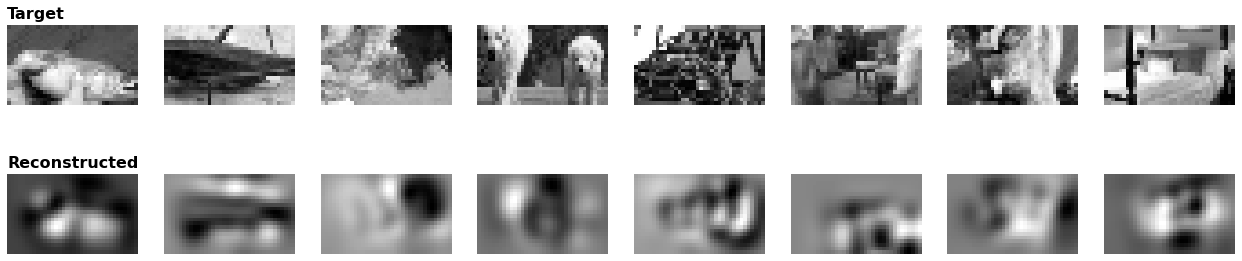

lr=1000, sigma=2.5, ker_sz=13   1.28795


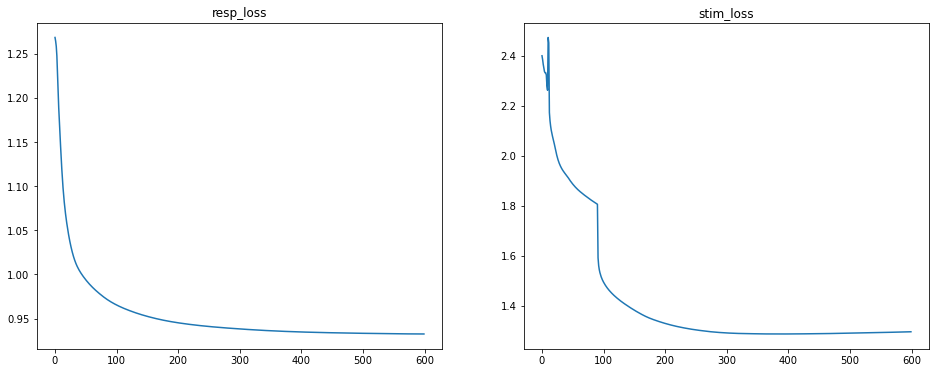

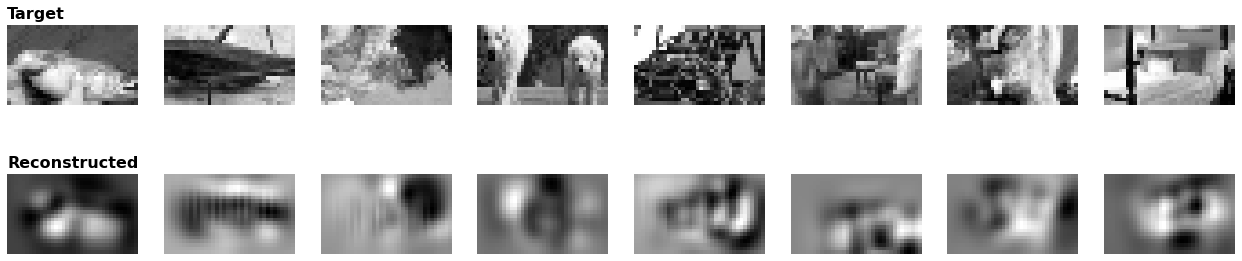

lr=1000, sigma=2.5, ker_sz=15   1.29234


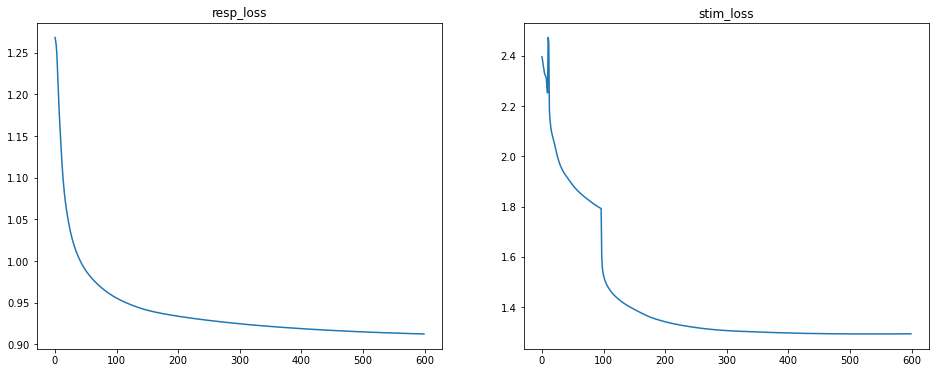

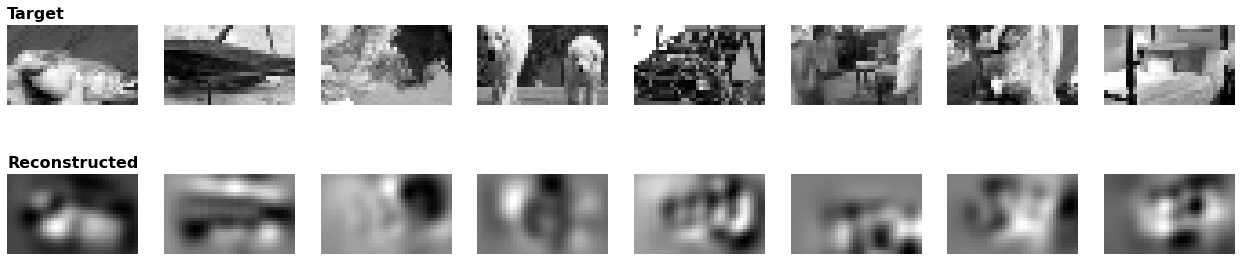

lr=1000, sigma=2.5, ker_sz=17   1.27776


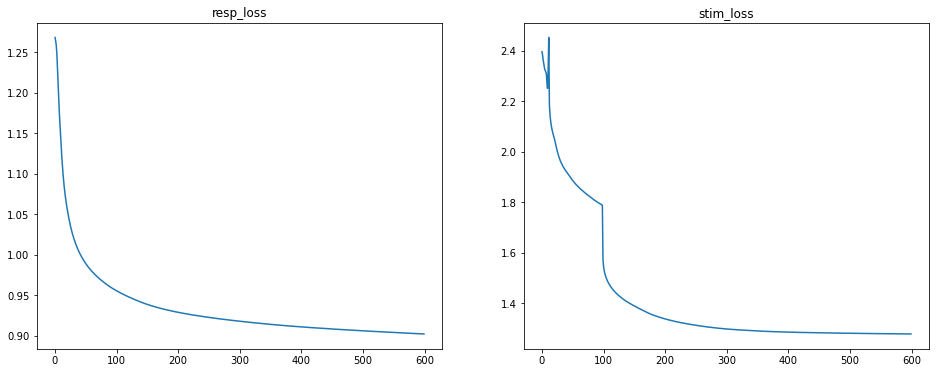

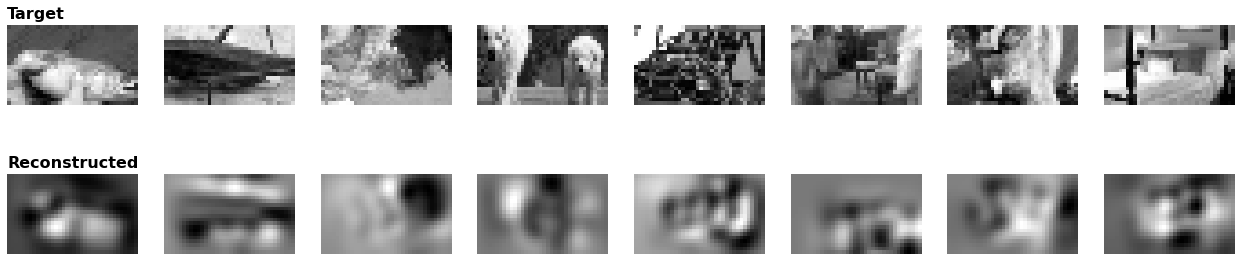

lr=1000, sigma=2.5, ker_sz=21   1.27755


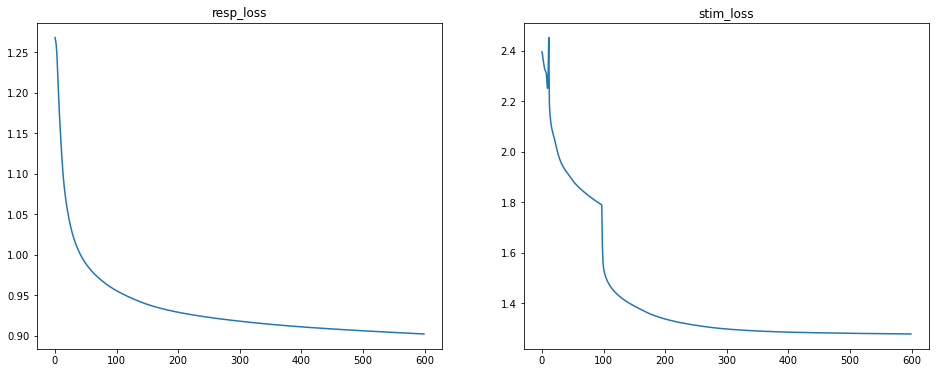

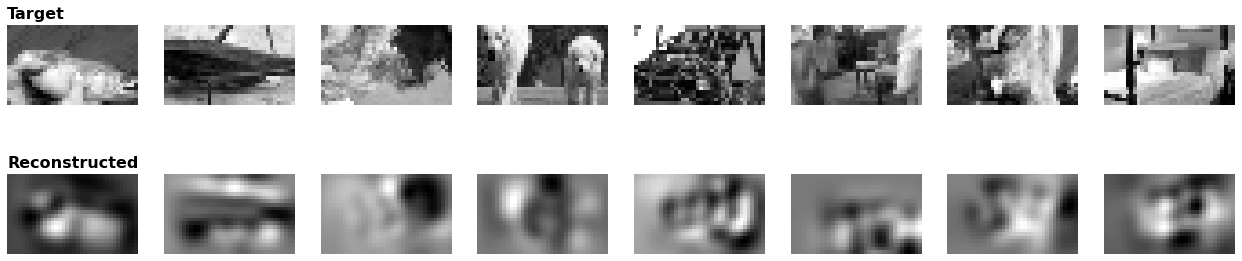

lr=2000, sigma=2.5, ker_sz=13   1.28733


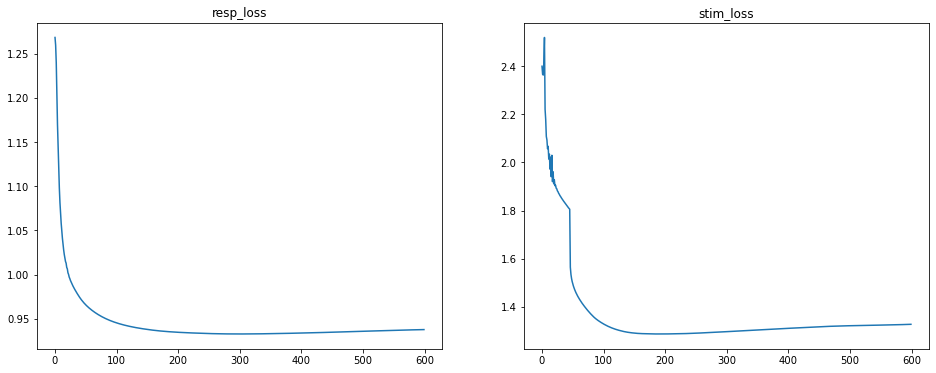

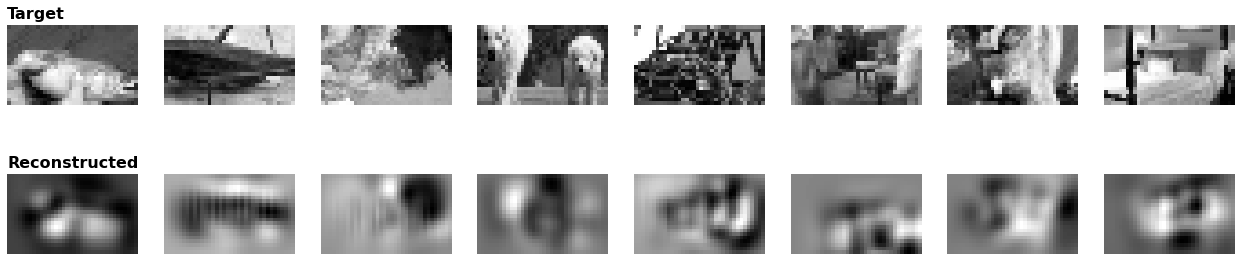

lr=2000, sigma=2.5, ker_sz=15   1.29292


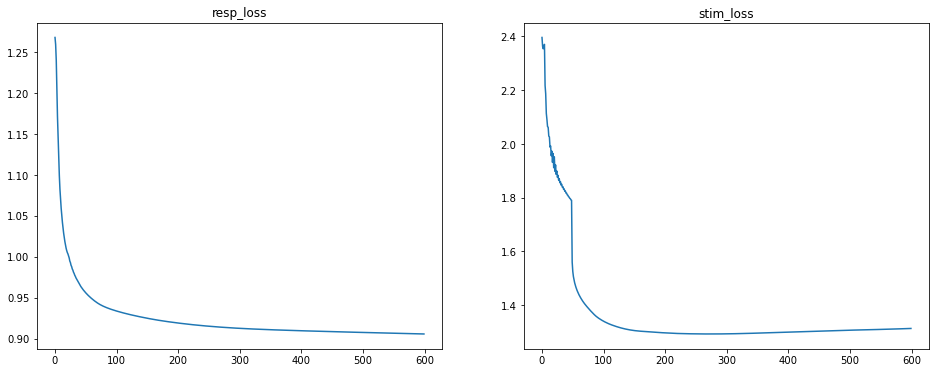

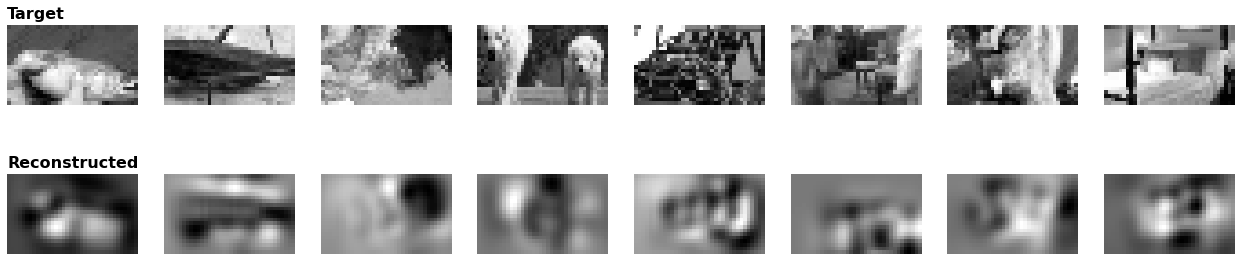

lr=2000, sigma=2.5, ker_sz=17   1.27744


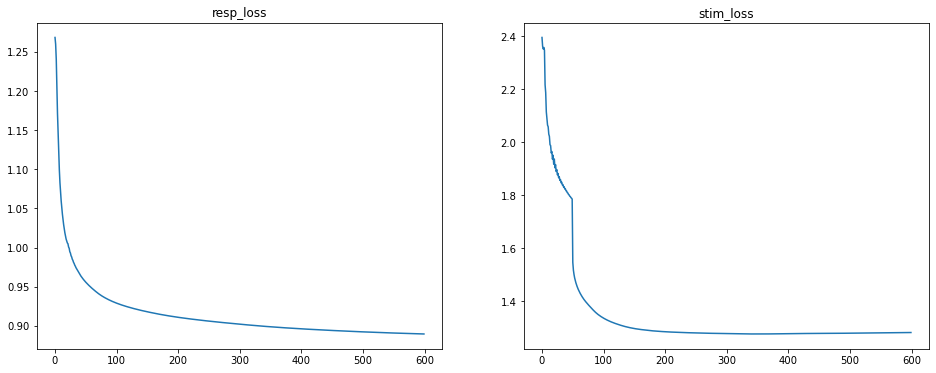

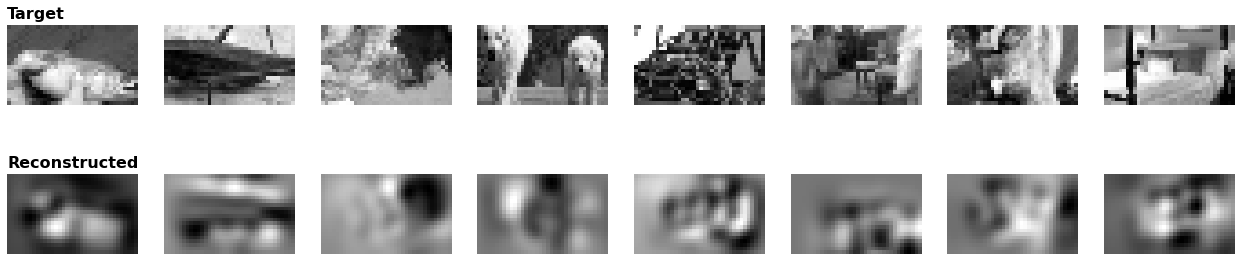

lr=2000, sigma=2.5, ker_sz=21   1.27737


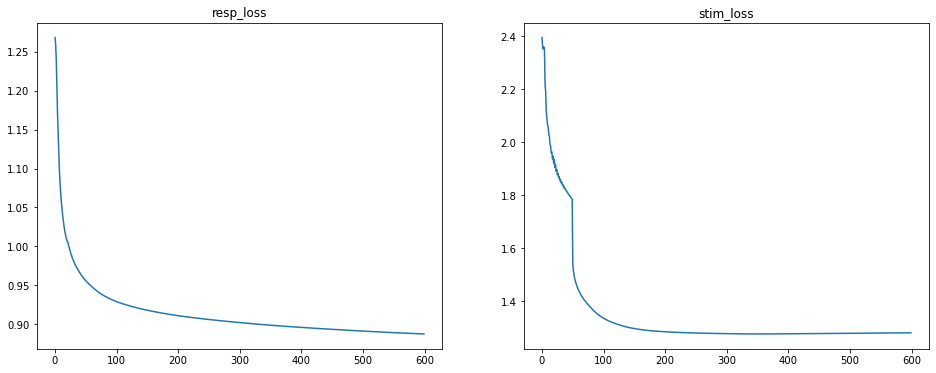

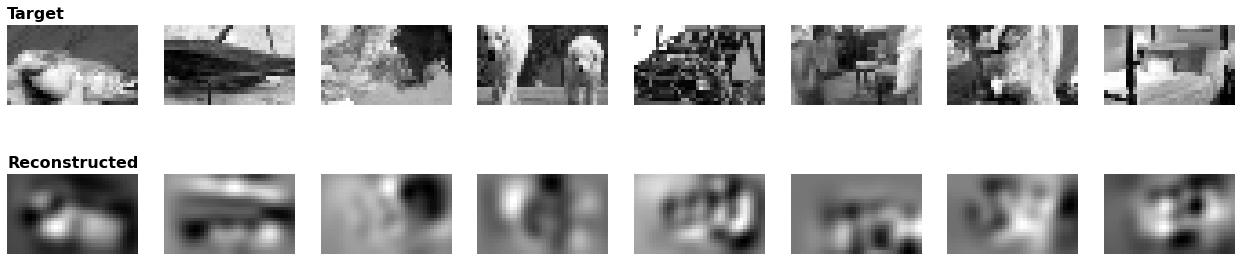

lr=1000, sigma=3.5, ker_sz=15   1.44270


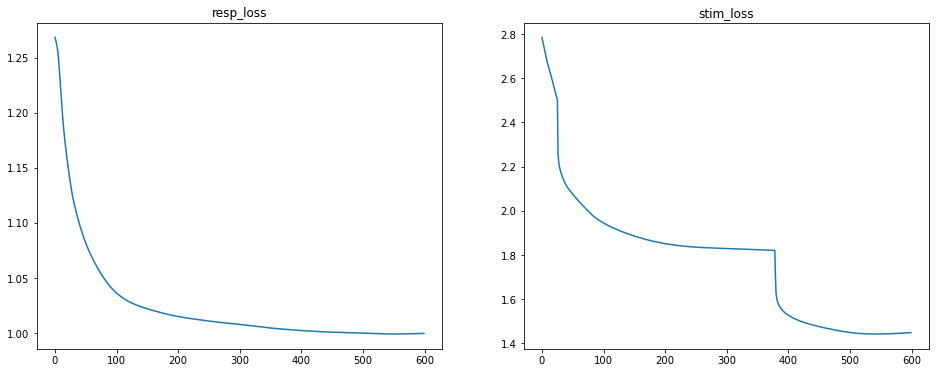

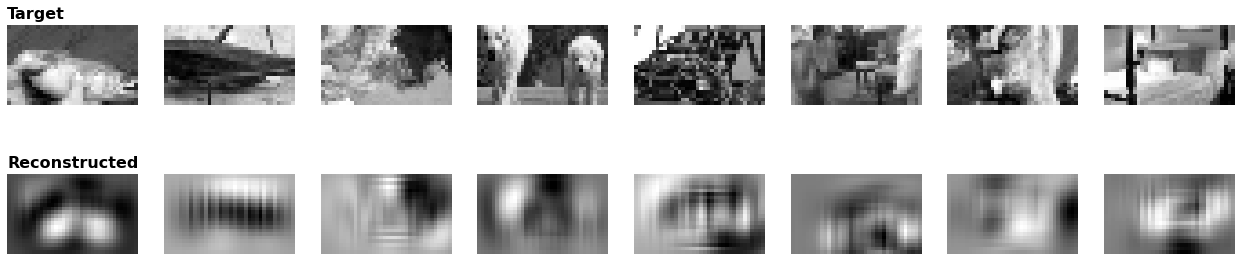

lr=1000, sigma=3.5, ker_sz=17   1.42741


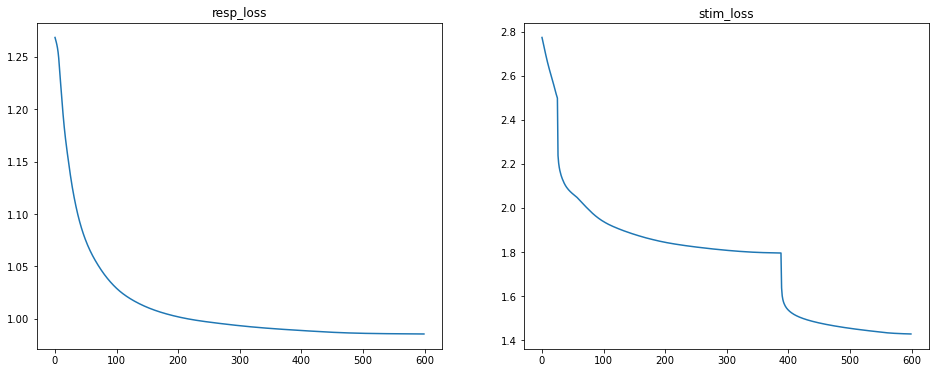

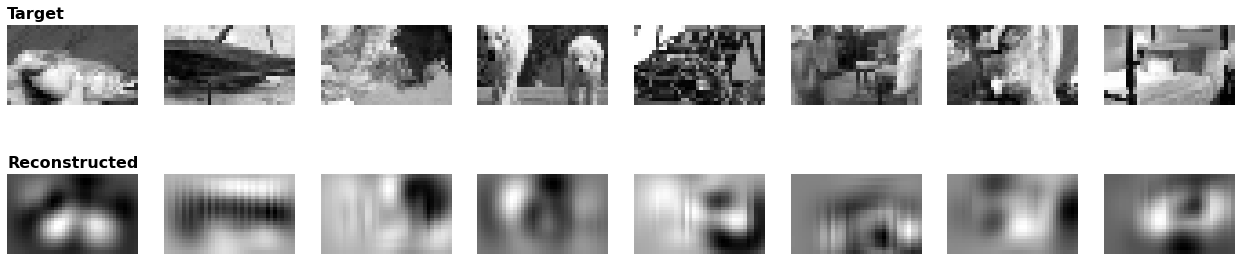

lr=1000, sigma=3.5, ker_sz=21   1.38791


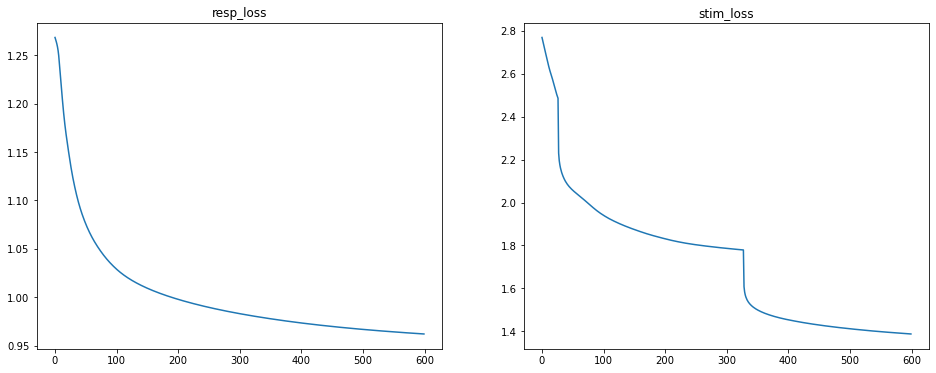

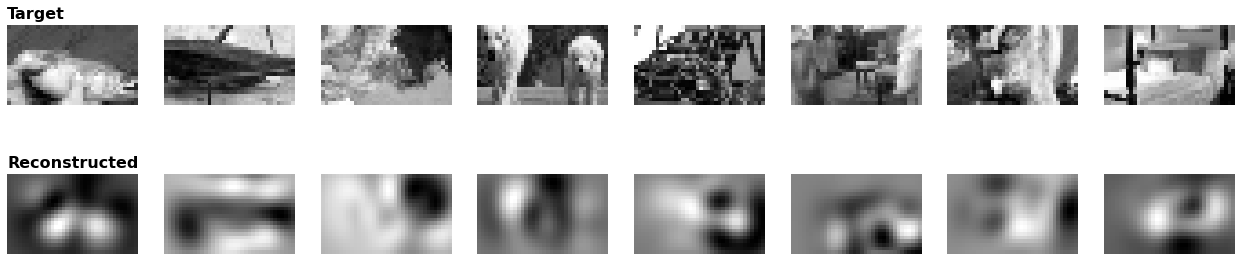

lr=1000, sigma=3.5, ker_sz=25   1.38358


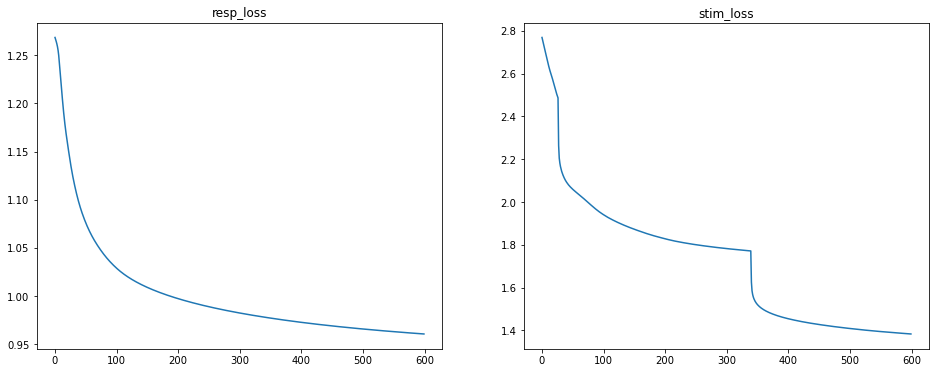

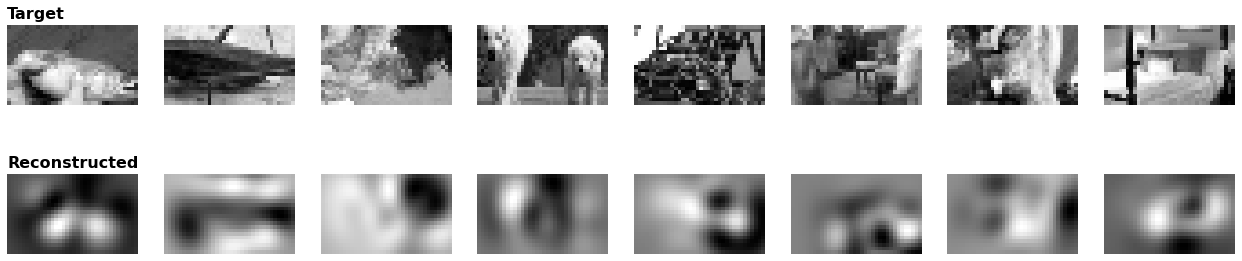

lr=2000, sigma=3.5, ker_sz=15   1.43730


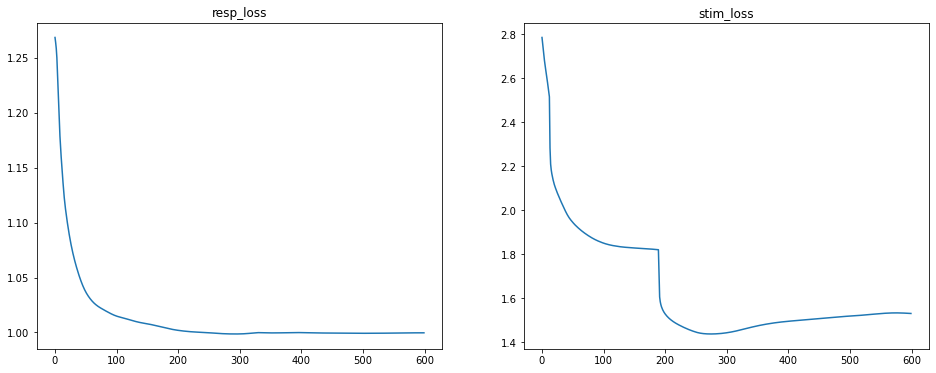

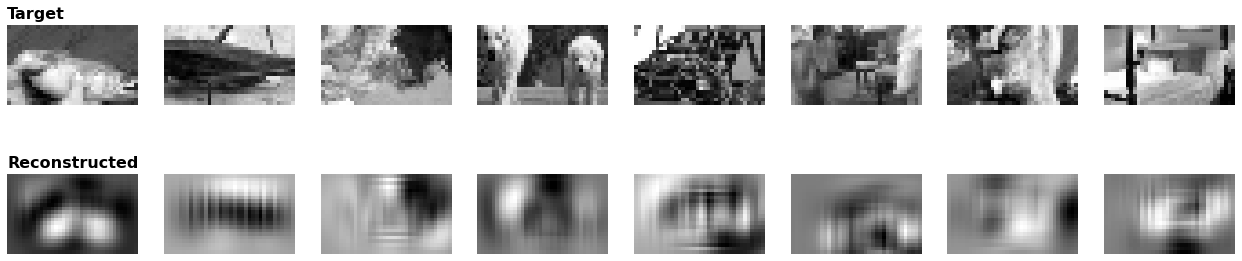

lr=2000, sigma=3.5, ker_sz=17   1.42464


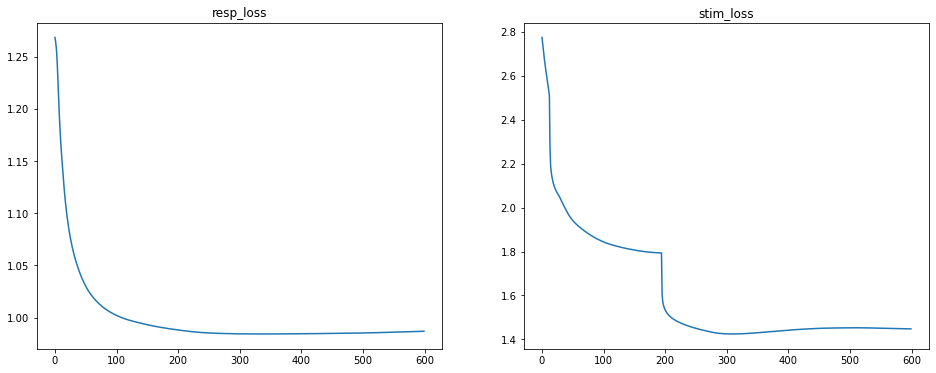

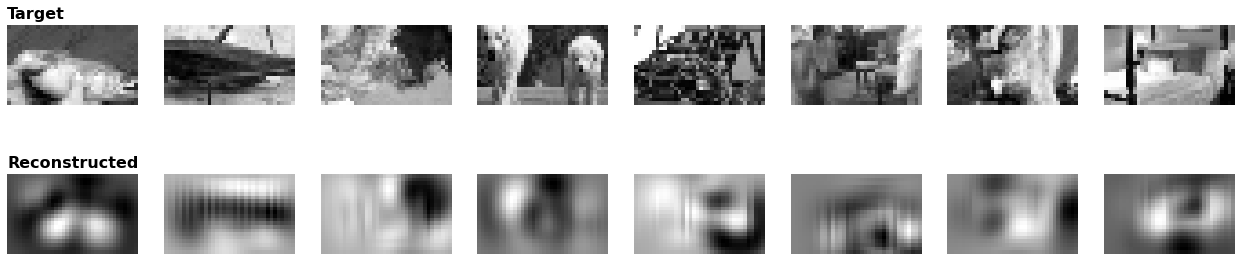

lr=2000, sigma=3.5, ker_sz=21   1.36581


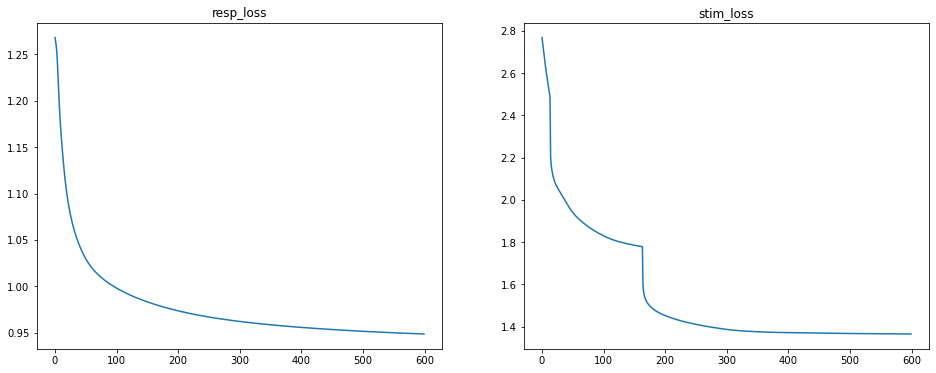

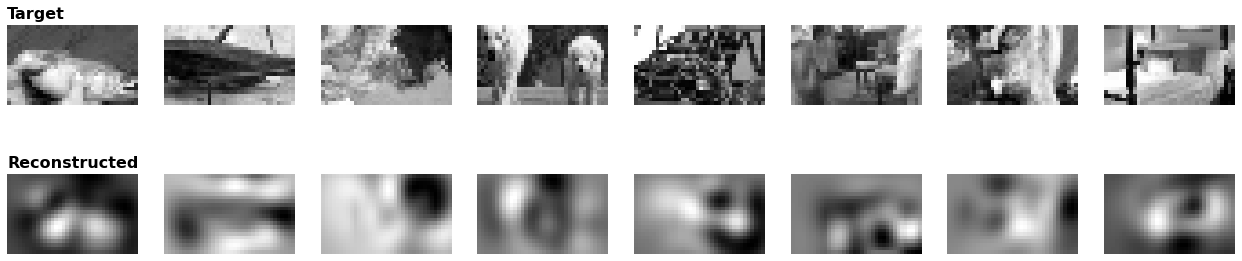

lr=2000, sigma=3.5, ker_sz=25   1.35602


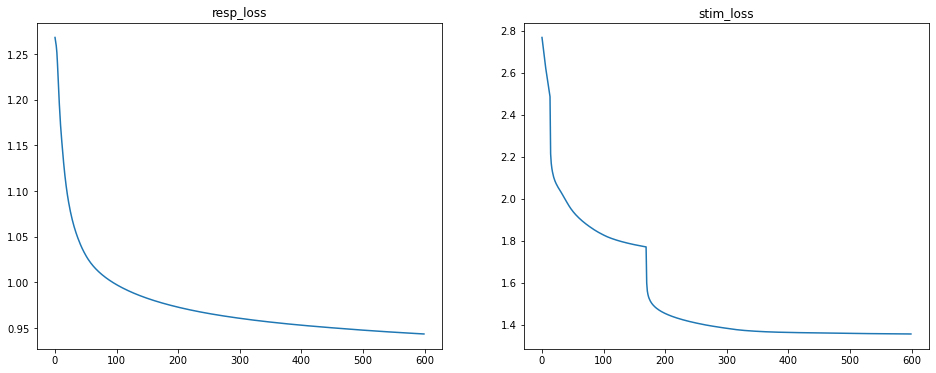

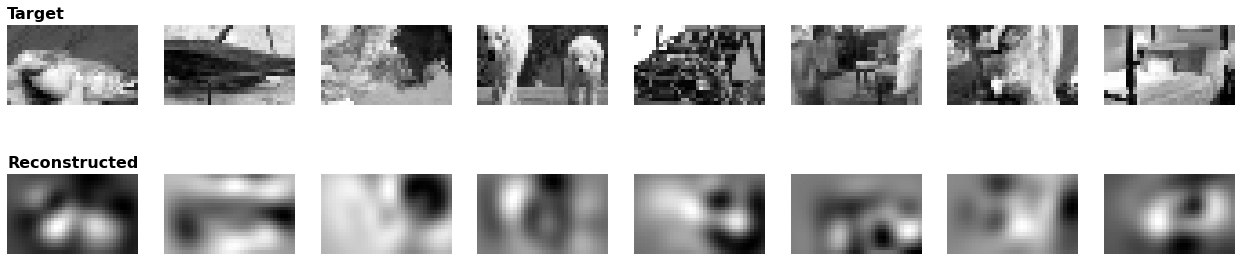

In [16]:
for r in results:
    print(
        f"lr={r['run_config']['enc_inv']['opter_config']['lr']}"
        f", sigma={r['run_config']['enc_inv']['img_grad_gauss_blur_config']['sigma']}"
        f", ker_sz={r['run_config']['enc_inv']['img_grad_gauss_blur_config']['kernel_size']}"
        f"   {r['history']['best']['stim_loss']:.5f}"
    )

    ### plot loss history
    plot_loss_history(history=r["history"])

    ### plot best results
    plot_comparison(target=crop(target_stim[:8], config["crop_win"]).cpu(),
                    pred=crop(r['history']['best']['stim_pred'][:8], config["crop_win"]).cpu())

#### Testing

In [6]:
from comparison_utils import get_metrics

DATA_PATH='/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22'


In [7]:
### Encoder inversion config
config["enc_inv"] = {
    "model": {
        "encoder": get_encoder(
            ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22.pth"),
            device=config["device"],
            eval_mode=True,
            # ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22_no_shifter.pth"),
        ),
        "img_dims": (1, 36, 64),
        "stim_pred_init": "zeros",
        "opter_cls": torch.optim.SGD,
        "opter_config": {"lr": 150, "momentum": 0.},
        "n_steps": 400,
        "resp_loss_fn": lambda resp_pred, resp_target: F.mse_loss(resp_pred, resp_target, reduction="none").mean(-1).sum(),
        "stim_loss_fn": None, # set below
        "img_gauss_blur_config": None,
        "img_grad_gauss_blur_config": {"kernel_size": 13, "sigma": 2.},
        "device": config["device"],
    },
    "loss_fns": get_metrics(config=config),
    "save_dir": os.path.join(DATA_PATH, "models", "inverted_encoder"),
    # "find_best_ckpt_according_to": "Perceptual Loss (VGG16)",
    "find_best_ckpt_according_to": "SSIML + PSL",
}
config["enc_inv"]["model"]["stim_loss_fn"] = config["enc_inv"]["loss_fns"][config["enc_inv"]["find_best_ckpt_according_to"]]
model = InvertedEncoder(**config["enc_inv"]["model"]).to(config["device"])

[INFO] Loading encoder checkpoint from /home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22/models/encoder_sens22.pth
[INFO] VGGPerceptualLoss: reduction=per_sample_mean_sum


In [45]:
config["enc_inv"]["model"]["n_steps"] = 500
config["enc_inv"]["model"]["img_grad_gauss_blur_config"] = {"kernel_size": 13, "sigma": 2.}
config["enc_inv"]["model"]["opter_config"] = {"lr": 500, "momentum": 0.}
model = InvertedEncoder(**config["enc_inv"]["model"]).to(config["device"])

In [46]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])
stim_pred, _, hist = model(
    resp_target=resp[:128],
    stim_target=stim[:128],
    additional_encoder_inp={
        "data_key": sample_data_key,
        "pupil_center": pupil_center[:128],
    }
)

In [29]:
from csng.losses import SSIM
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM2

In [35]:
ssim = SSIM(size_average=False)
ssim2 = SSIM2(reduction="none")

In [39]:
ssim(standardize(stim_pred), standardize(stim)[:128]), ssim2(standardize(stim_pred), standardize(stim)[:128])

(tensor[128] x∈[0.031, 0.512] μ=0.158 σ=0.069 cuda:0,
 tensor[128] x∈[0.031, 0.512] μ=0.158 σ=0.069 cuda:0)

In [37]:
ssim(stim_pred, stim[:128]), ssim2(stim_pred, stim[:128])

(tensor[128] x∈[-0.039, 0.141] μ=0.037 σ=0.032 cuda:0,
 tensor[128] x∈[-0.021, 0.448] μ=0.176 σ=0.088 cuda:0)

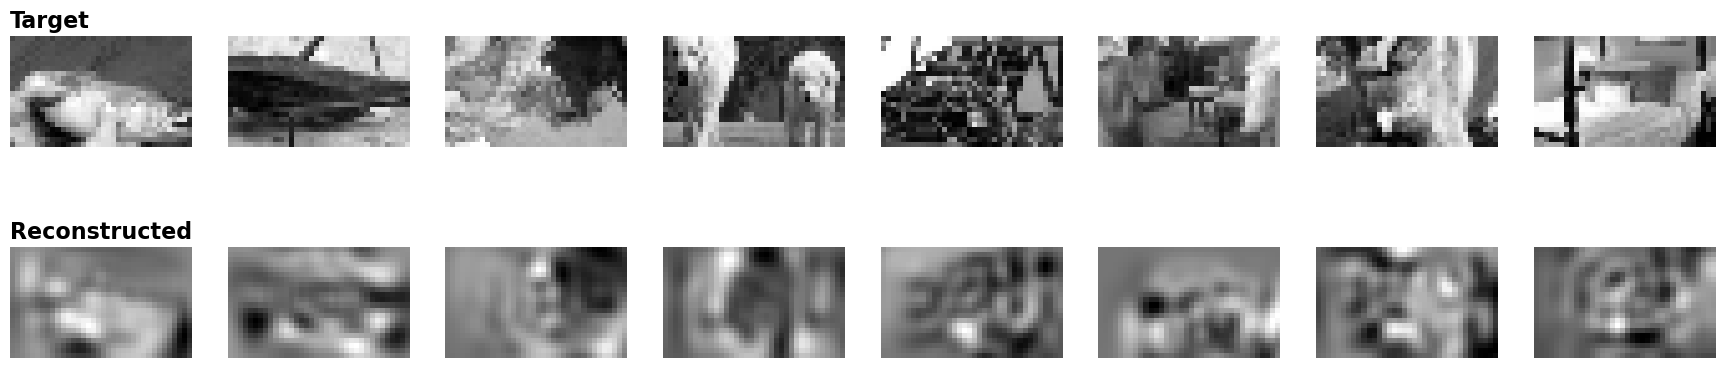

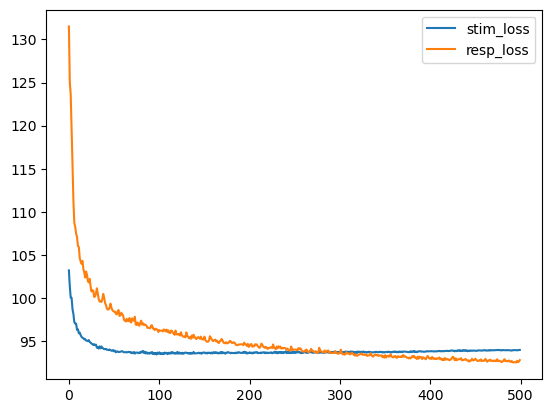

In [47]:
_ = plot_comparison(target=crop(stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).cpu())
plt.plot(hist["stim_loss"], label="stim_loss")
plt.plot(hist["resp_loss"], label="resp_loss")
plt.legend()